#### By: Peyman Shahidi
#### Created: Nov 3, 2025
#### Last Edit: Nov 9, 2025

<br>

In [181]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [182]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT'
output_plot_path = f"{main_folder_path}/writeup/plots/ONET_Eloundou_Anthropic_GPT"
embedding_model_path = f"{input_data_path}/sentence-transformers/all-MiniLM-L6-v2"

In [183]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

# Frequent Tasks Analysis or All Tasks Switch

In [184]:
frequent_tasks_analysis = False

# 1) Read O*NET Dataset

In [185]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


# 2) Read and Merge with Eloundou et al.'s AI Exposure Dataset

In [186]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")

Number of rows in GPTs full labels dataset: 19,265


In [187]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


# 3) Read and Merge with Anthropic's AI Use Dataset

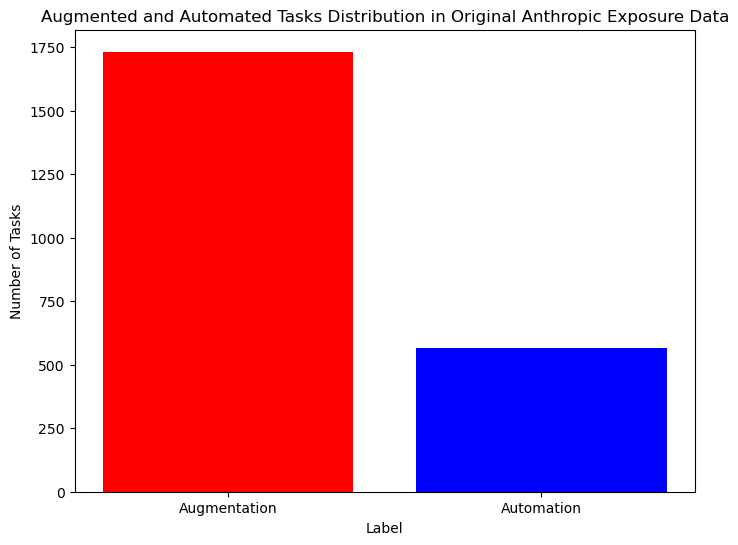

In [188]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue'])
plt.title('Augmented and Automated Tasks Distribution in Original Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
plt.savefig(f'{output_plot_path}/anthropicIndex_automatedAugmented_taskDist.png')
plt.show()

In [189]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

# Drop temporary columns used for merging
merged_data = merged_data.drop(columns=['task_normalized', 'task_name'])

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


# 4) Read and Merge with GPT 5-o Mini's Task Sequence Data

In [190]:
if not frequent_tasks_analysis:
    # Read task sequence data
    # Go through computed_objects/tasks_sequences and read all files and merge with original ONET data
    # Get list of files in the directory
    task_sequence_files = [f for f in os.listdir(f'{input_data_path}/computed_objects/tasks_sequences') if f.endswith('.csv')]
    task_sequence = pd.concat([pd.read_csv(f'{input_data_path}/computed_objects/tasks_sequences/{file}') for file in task_sequence_files], ignore_index=True)

    print(f"Task sequence data shape: {task_sequence.shape}")
    print(f"Columns in task sequence: {list(task_sequence.columns)}")

    # Merge task sequence data with merged_data
    merged_data = pd.merge(merged_data, task_sequence[['O*NET-SOC Code', 'Task ID', 'Task Position']], on=['O*NET-SOC Code', 'Task ID'], how='left')
    merged_data = merged_data[merged_data['Task Position'].notna()].reset_index(drop=True)
    merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce').astype('Int64')

    # Bring the "Task Position" column next to "Task ID" for better readability
    task_position_col = merged_data.pop('Task Position')
    merged_data.insert(merged_data.columns.get_loc('Task Title') + 1, 'Task Position', task_position_col)

else:
    # Modify output paths for frequent tasks analysis
    output_data_path = f'{input_data_path}/computed_objects/ONET_Eloundou_Anthropic_GPT_frequent'
    os.makedirs(output_data_path, exist_ok=True)
    output_plot_path = f"{main_folder_path}/writeup/plots/ONET_Eloundou_Anthropic_GPT_frequent"
    os.makedirs(output_plot_path, exist_ok=True)
    
    # Read task sequence data for frequent tasks
    # Go through computed_objects/tasks_sequences_frequent and read all files and merge with original ONET data
    # Get list of files in the directory
    task_sequence_files = [f for f in os.listdir(f'{input_data_path}/computed_objects/tasks_sequences_frequent') if f.endswith('.csv')]
    task_sequence = pd.concat([pd.read_csv(f'{input_data_path}/computed_objects/tasks_sequences_frequent/{file}') for file in task_sequence_files], ignore_index=True)

    print(f"Task sequence data shape: {task_sequence.shape}")
    print(f"Columns in task sequence: {list(task_sequence.columns)}")


    # Define frequency importance threshold (in %):
    freq_importance_threshold = 65

    # Filter tasks based on frequency importance threshold
    merged_data['frequent_task'] = merged_data['FT_Daily'] + merged_data['FT_Several times daily'] + merged_data['FT_Hourly or more']
    print(f"Total tasks before filtering: {len(merged_data)}")

    # Length of ONET for different filtering thresholds:
    print("Length of ONET for different frequency importance thresholds:")
    for threshold in [50, 60, 70, 80, 90]:
        filtered_merged_data = merged_data[merged_data['frequent_task'] >= threshold]
        print(f"  - Threshold {threshold}%: {len(filtered_merged_data)} tasks")


    merged_data = merged_data[merged_data['frequent_task'] >= freq_importance_threshold].reset_index(drop=True)
    print(f"Total tasks after filtering infrequent ones: {len(merged_data)}")

    # Remove occupations with three or less frequent tasks
    frequent_tasks_per_occupation_threshold = 3
    occupation_task_counts = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
    valid_occupations = occupation_task_counts[occupation_task_counts >= frequent_tasks_per_occupation_threshold].index
    merged_data = merged_data[merged_data['O*NET-SOC Code'].isin(valid_occupations)].reset_index(drop=True)

    # Merge task sequence data with merged_data
    merged_data = pd.merge(merged_data, task_sequence[['O*NET-SOC Code', 'Task ID', 'Task Position']], on=['O*NET-SOC Code', 'Task ID'], how='left')
    merged_data = merged_data[merged_data['Task Position'].notna()].reset_index(drop=True)
    merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce').astype('Int64')

    # Bring the "Task Position" column next to "Task ID" for better readability
    task_position_col = merged_data.pop('Task Position')
    merged_data.insert(merged_data.columns.get_loc('Task Title') + 1, 'Task Position', task_position_col)

Task sequence data shape: (17926, 5)
Columns in task sequence: ['Task Position', 'Task Title', 'Task ID', 'O*NET-SOC Code', 'Occupation Title']


In [191]:
# # Drop the supplemental tasks
# merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# # Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
# merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [192]:
# Sort values of merged data before saving
merged_data = merged_data.sort_values(by=['O*NET-SOC Code', 'Task Position'])

# Save merged dataset
os.makedirs(output_data_path, exist_ok=True)
# merged_data.to_csv(f'{output_data_path}/ONET_Eloundou_Anthropic_GPT.csv', index=False)

merged_data.head()

,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Position,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,...,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,automation,augmentation,label
30,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",1,Core,5,2.12,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,0.36,0.53,Augmentation
24,11-1011.00,Chief Executives,8848,Direct or conduct studies or research on issue...,2,Core,5,0.78,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E1,NaN,NaN,Manual
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,3,Core,5,9.22,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2,0.31,0.66,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",4,Core,5,9.49,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E0,E0,0.25,0.61,Augmentation
10,11-1011.00,Chief Executives,8833,"Preside over, or serve on, boards of directors...",5,Core,5,1.46,124.47,38.46,...,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E0,E0,NaN,NaN,Manual


## Implement Task Embeddings

In [193]:
import importlib.metadata, subprocess, sys
def pip_install_if_needed(pkg, min_v):
    try:
        v = importlib.metadata.version(pkg)
        if v >= min_v:
            print(f"{pkg} {v} OK")
            return
    except importlib.metadata.PackageNotFoundError:
        print(f"{pkg} not found")
    subprocess.check_call([sys.executable, "-m", "pip", "install", f"{pkg}>={min_v}", "-U"])

pip_install_if_needed("sentence-transformers", "3.1.0")

sentence-transformers 5.1.2 OK


In [194]:
import time
import numpy as np, pandas as pd
from sklearn.preprocessing import normalize

from sentence_transformers import SentenceTransformer
model = SentenceTransformer(embedding_model_path, device="cpu")
print("Model OK:", len(model.encode(["test"])[0]))

# encode O*NET task statements (small batch for responsiveness)
texts = merged_data['Task Title'].astype(str).tolist()
if len(texts) == 0:
    raise ValueError('merged_data has no Task Title rows to encode')

start = time.time()
emb = model.encode(texts, batch_size=16, normalize_embeddings=True, show_progress_bar=True, convert_to_numpy=True)
print(f'Encoded {len(texts)} texts in {time.time() - start:.2f}s; embedding shape: {emb.shape}')

# Ensure embeddings are L2-normalized (sentence-transformers can do this via normalize_embeddings=True but double-check)
E = emb.astype(float)
norms = np.linalg.norm(E, axis=1)
if not np.allclose(norms, 1.0, atol=1e-3):
    E = normalize(E, norm='l2')

merged_data['idx'] = np.arange(len(merged_data))

# fast mean pairwise cosine similarity per SOC (O(n), no n^2 matrix):
def mean_pairwise_cosine(E_soc, w=None):
    # E_soc: array (n, d) of L2-normalized vectors
    if E_soc.shape[0] <= 1:
        return np.nan
    if w is None:
        w = np.ones(E_soc.shape[0])
    w = np.asarray(w, dtype=float)
    if w.sum() == 0:
        w = np.ones_like(w)
    w = w / w.sum()
    s = (E_soc * w[:, None]).sum(axis=0)            # weighted centroid
    num = (s @ s) - (w @ w)                          # sum_{i!=j} w_i w_j cos_ij
    den = 1.0 - (w @ w)                              # sum_{i!=j} w_i w_j
    return num / den if den > 0 else np.nan

out = []
for soc, g in merged_data.groupby('O*NET-SOC Code', sort=False):
    ids = g['idx'].values.astype(int)
    # optional weights column 'w' (importance*frequency). If missing or all-NaN, use uniform weights
    if 'w' in g.columns and g['w'].notna().any():
        w = g['w'].fillna(0).values.astype(float)
    else:
        w = None
    E_soc = E[ids]
    mcos = mean_pairwise_cosine(E_soc, w)
    dispersion = 1 - mcos                     # higher = more semantically heterogeneous
    out.append({'O*NET-SOC Code': soc, 'task_semantic_dispersion': dispersion, 'mean_cos_sim': mcos})

disp = pd.DataFrame(out)
print('Done. `disp` dataframe created with', len(disp), 'rows')
disp

Model OK: 384


Batches:   0%|          | 0/1121 [00:00<?, ?it/s]

Encoded 17925 texts in 28.99s; embedding shape: (17925, 384)
Done. `disp` dataframe created with 872 rows


,O*NET-SOC Code,task_semantic_dispersion,mean_cos_sim
0,11-1011.00,0.59,0.41
1,11-1011.03,0.42,0.58
2,11-1021.00,0.60,0.40
3,11-2011.00,0.60,0.40
4,11-2021.00,0.59,0.41
...,...,...,...
867,53-7071.00,0.68,0.32
868,53-7072.00,0.64,0.36
869,53-7073.00,0.59,0.41
870,53-7081.00,0.64,0.36
